In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# ensure we can load the src folder from this notebook
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(f"numpy: {np.__version__}")
print(f"opencv: {cv2.__version__}"),
print(f"tensorflow: {tf.__version__}")

numpy: 1.19.5
opencv: 4.5.1
tensorflow: 2.4.1


In [2]:
# OPTIONAL: Load the \"autoreload\" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.preprocess import *
from src.i3d_inception import Inception_Inflated3d

# Experiment 1
The goal of this experiment is to get a baseline. no fancy bells and whistles.

## Define the parameters
First loop over all the class_names in the `test` folder and count the number of files per `video`

In [3]:
test_dir = os.path.join('data', 'assignment', 'test')

meta_data = []
for class_name in os.listdir(test_dir):
    for video_name in os.listdir(os.path.join(test_dir, class_name)):
        meta_data.append({
            'class_name':class_name,
            'video_name':video_name,
            'nr_files':len(os.listdir(os.path.join(test_dir, class_name, video_name))),
        })

meta_data_frame = pd.DataFrame(meta_data)
meta_data_frame.head()

,class_name,video_name,nr_files
0,Diving,g24_c01,93
1,Diving,g23_c04,169
2,Diving,g23_c02,72
3,Diving,g22_c04,184
4,Diving,g21_c04,269


Whats the distribution of the nr_files?

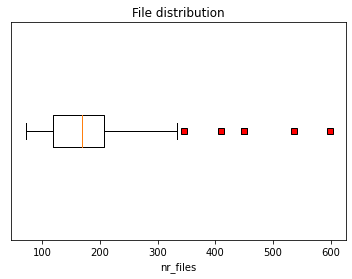

In [4]:
plt.title('File distribution')
plt.boxplot(meta_data_frame['nr_files'], vert=False, flierprops=dict(markerfacecolor='r', marker='s'))
plt.xlabel("nr_files")
plt.yticks([])
plt.show()

Since the model expects a fixed amount of files (for `INPUT_SHAPE`) let's for now pick the smallest. 

TODO: if the confidence is low, we could experiment with discrete bins and thus different input layers

In [5]:
INPUT_SHAPE = min(meta_data_frame['nr_files'])
INPUT_SHAPE

72

Load the labelmap, and extract the number of classes from it

In [6]:
LABEL_MAP_PATH = 'data/label_map.txt'

kinetics_classes = [x.strip() for x in open(LABEL_MAP_PATH, 'r')]
NUM_CLASSES = len(kinetics_classes)
NUM_CLASSES

400

Define the image dimensions

TODO: we could vary with different dimensions

In [7]:
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_RGB_CHANNELS = 3
NUM_FLOW_CHANNELS = 2

## Load the models

In [8]:
rgb_model = Inception_Inflated3d(
    include_top=True,
    weights='rgb_imagenet_and_kinetics',
    input_shape=(INPUT_SHAPE, FRAME_HEIGHT, FRAME_WIDTH, NUM_RGB_CHANNELS),
    classes=NUM_CLASSES
)

# flow_model = Inception_Inflated3d(
#     include_top=True,
#     weights='flow_imagenet_and_kinetics',
#     input_shape=(INPUT_SHAPE, FRAME_HEIGHT, FRAME_WIDTH, NUM_FLOW_CHANNELS),
#     classes=NUM_CLASSES
# )

## Make predictions

In [9]:
for class_name in os.listdir(test_dir):
    for video_name in os.listdir(os.path.join(test_dir, class_name)):
        print(f"=============================================================================")
        print(f"class_name: {class_name}")
        print(f"video_name: {video_name}")
        
        # get the first x files from the directory 
        files = sorted(os.listdir(os.path.join(test_dir, class_name, video_name)))[:INPUT_SHAPE]
        
        # map the files to file paths
        file_paths = [os.path.join(test_dir, class_name, video_name, file) for file in files]
        
        # collect the rgb files
        npy_rgb_output = f"data/interim/{class_name}_{video_name}_rgb.npy"
        if not os.path.exists(npy_rgb_output):
            rgb = run_rgb(file_paths)
            np.save(npy_rgb_output, rgb)
        rgb_sample = np.load(npy_rgb_output)
        
        # collect the optical flow files
#         npy_flow_output = f"data/interim/{class_name}_{video_name}_flow.npy"
#         if not os.path.exists(npy_rgb_output):
#             flow = run_flow(file_paths)
#             np.save(npy_flow_output, flow)
        
        # make prediction
        rgb_logits = rgb_model.predict(rgb_sample)
        
        # produce final model logits
        sample_logits = rgb_logits
        
        # produce softmax output from model logit for class probabilities
        sample_logits = sample_logits[0] # we are dealing with just one example
        sample_predictions = np.exp(sample_logits) / np.sum(np.exp(sample_logits))
        
        sorted_indices = np.argsort(sample_predictions)[::-1]
        
        print('\nNorm of logits: %f' % np.linalg.norm(sample_logits))
        print('\nTop 20 classes and probabilities')
        for index in sorted_indices[:20]:
            print(sample_predictions[index], sample_logits[index], kinetics_classes[index])
            
# for class_name in os.listdir(test_dir):
#     for video_name in os.listdir(os.path.join(test_dir, class_name)):
#         print(f"=============================================================================")
#         print(f"class_name: {class_name}")
#         print(f"video_name: {video_name}")
        
#         # get the first x files from the directory 
#         files = sorted(os.listdir(os.path.join(test_dir, class_name, video_name)))[:INPUT_SHAPE]
        
#         # map the files to file paths
#         file_paths = [os.path.join(test_dir, class_name, video_name, file) for file in files]
        
#         # collect the rgb files
#         npy_rgb_output = f"data/interim/{class_name}_{video_name}_rgb.npy"
#         if not os.path.exists(npy_rgb_output):
#             rgb = run_rgb(file_paths)
#             np.save(npy_rgb_output, rgb)
#         rgb_sample = np.load(npy_rgb_output)
        
#         # collect the optical flow files
#         npy_flow_output = f"data/interim/{class_name}_{video_name}_flow.npy"
#         if not os.path.exists(npy_flow_output):
#             flow = run_flow(file_paths)
#             np.save(npy_flow_output, flow)
#         flow_sample = np.load(npy_flow_output)
        
#         # make prediction
#         rgb_logits = rgb_model.predict(rgb_sample)
#         flow_logits = flow_model.predict(flow_sample)
        
#         # produce final model logits
#         sample_logits = rgb_logits + flow_logits
        
#         # produce softmax output from model logit for class probabilities
#         sample_logits = sample_logits[0] # we are dealing with just one example
#         sample_predictions = np.exp(sample_logits) / np.sum(np.exp(sample_logits))
        
#         sorted_indices = np.argsort(sample_predictions)[::-1]
        
#         print('\nNorm of logits: %f' % np.linalg.norm(sample_logits))
#         print('\nTop 20 classes and probabilities')
#         for index in sorted_indices[:20]:
#             print(sample_predictions[index], sample_logits[index], kinetics_classes[index])

class_name: Diving
video_name: g24_c01

Norm of logits: 72.347000

Top 20 classes and probabilities
0.6798788 15.548179 springboard diving
0.28446683 14.676881 somersaulting
0.021032969 12.072355 slacklining
0.0057632085 10.777759 parkour
0.002698821 10.019079 bungee jumping
0.0023139233 9.865209 faceplanting
0.0007205085 8.698466 riding unicycle
0.00048700752 8.306788 bouncing on trampoline
0.0003409673 7.9502954 jumping into pool
0.00020660742 7.4493294 skateboarding
0.00019902809 7.411955 high kick
0.00017545423 7.2858872 dunking basketball
0.00016152146 7.203147 drop kicking
0.00014549399 7.098644 squat
0.00014405664 7.0887156 feeding fish
0.000129707 6.983787 swinging on something
0.00012423251 6.940664 gymnastics tumbling
0.000121741476 6.9204087 climbing ladder
9.284963e-05 6.6494904 headbutting
7.2443625e-05 6.4013176 cleaning windows
class_name: Diving
video_name: g23_c04

Norm of logits: 82.642647

Top 20 classes and probabilities
0.89621776 18.640902 springboard diving
0.096

# Experiment 2